In [20]:
import scipy.io
import matplotlib.pyplot as plt

data = scipy.io.loadmat('Brain.mat')

data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'T1', 'label'])

In [21]:
mri_stacked = data['T1']
mri_labels = data['label']

print(mri_stacked.shape)
print(mri_labels.shape)

(362, 434, 10)
(362, 434, 10)


In [22]:
# Max and min label
print(mri_labels[:,:,0].max())
print(mri_labels[:,:,0].min())

5
0


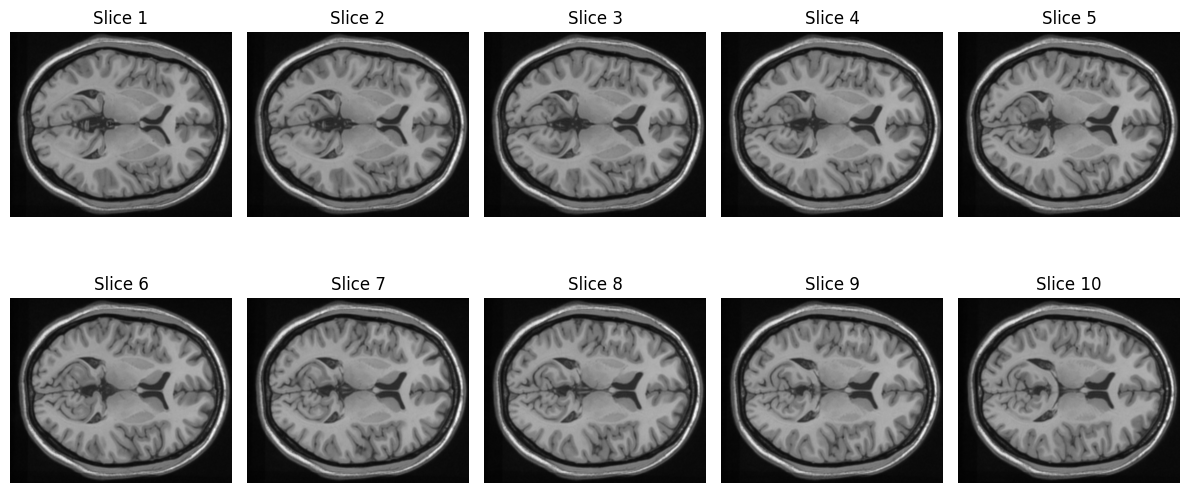

In [23]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_stacked[:, :, i], cmap='gray')
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

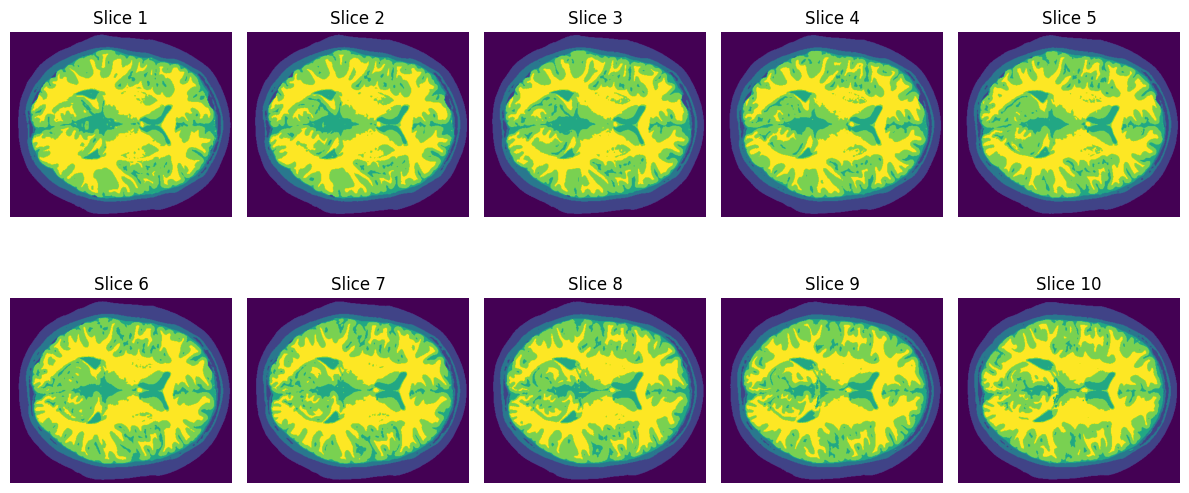

In [24]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    ax.imshow(mri_labels[:, :, i])
    ax.set_title(f'Slice {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()

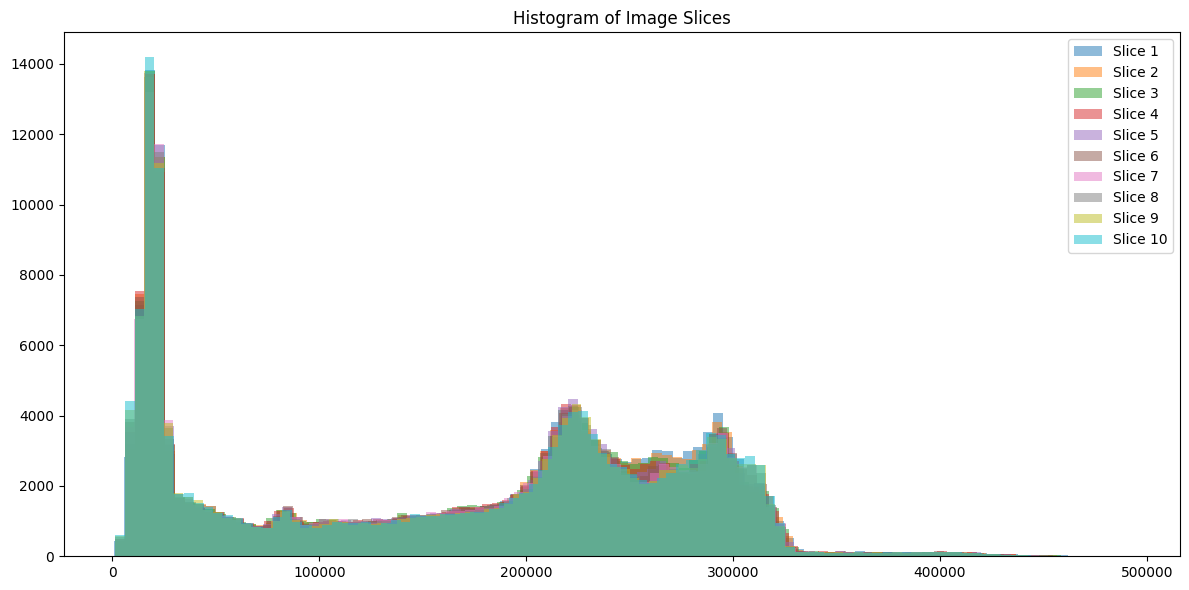

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

for i in range(mri_stacked.shape[2]):
    hist = plt.hist(mri_stacked[:, :, i].flatten(), bins=100, alpha=0.5, label=f'Slice {i+1}')

ax.set_title('Histogram of Image Slices')
ax.legend()

plt.tight_layout()
plt.show()


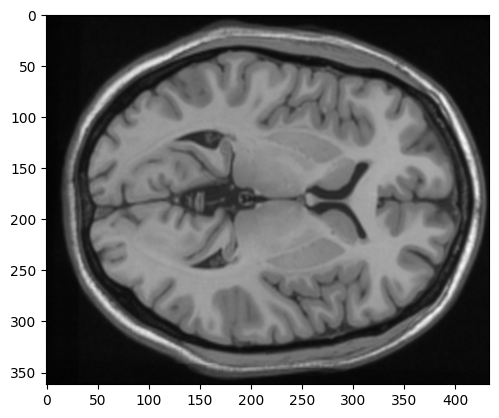

In [26]:
reference_img = mri_stacked[:,:,0]
plt.imshow(reference_img, cmap='gray')

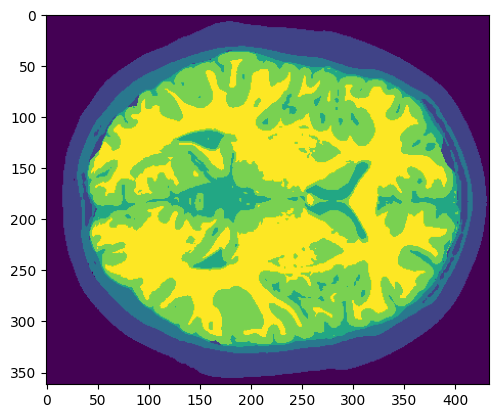

In [27]:
reference_labels = mri_labels[:,:,0]
plt.imshow(reference_labels)

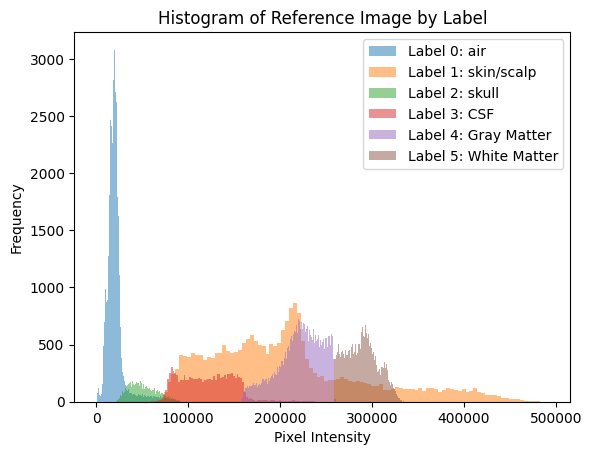

In [28]:
import numpy as np

# Flatten the reference_labels
labels_flat = reference_labels

# Label names
label_names = ['air', 'skin/scalp', 'skull', 'CSF', 'Gray Matter', 'White Matter']


# Initialize an empty list to store the histograms
histograms = []

# Iterate over unique labels
for label in np.unique(labels_flat):
    # Select the pixels with the current label
    pixels = reference_img[labels_flat == label]
    
    # Plot the histogram of the selected pixels
    hist = plt.hist(pixels.flatten(), bins=100, alpha=0.5, label=f'Label {label}: {label_names[label]}')
    
    # Append the histogram to the list
    histograms.append(hist)

# Show the legend
plt.legend()

# Set the title and labels
plt.title('Histogram of Reference Image by Label')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')

# Show the plot
plt.show()


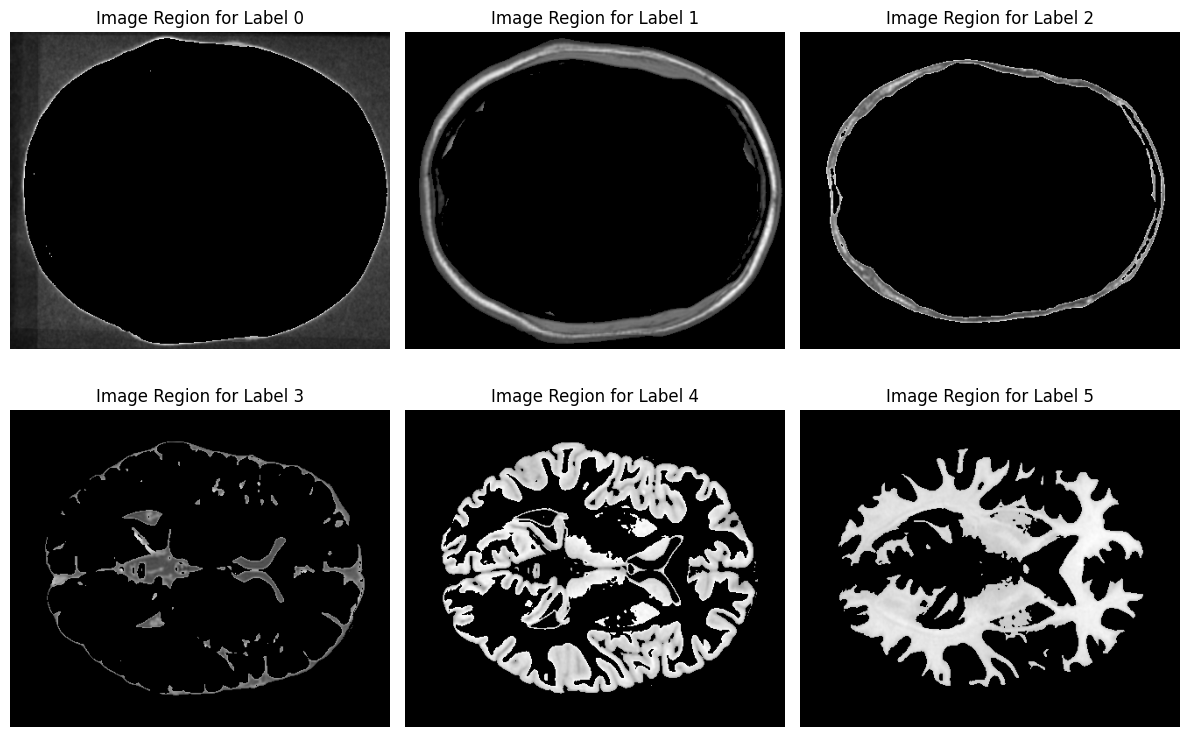

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = reference_img * (reference_labels == i)
    ax.imshow(mask.reshape(reference_img.shape), cmap='gray')
    ax.set_title(f'Image Region for Label {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()


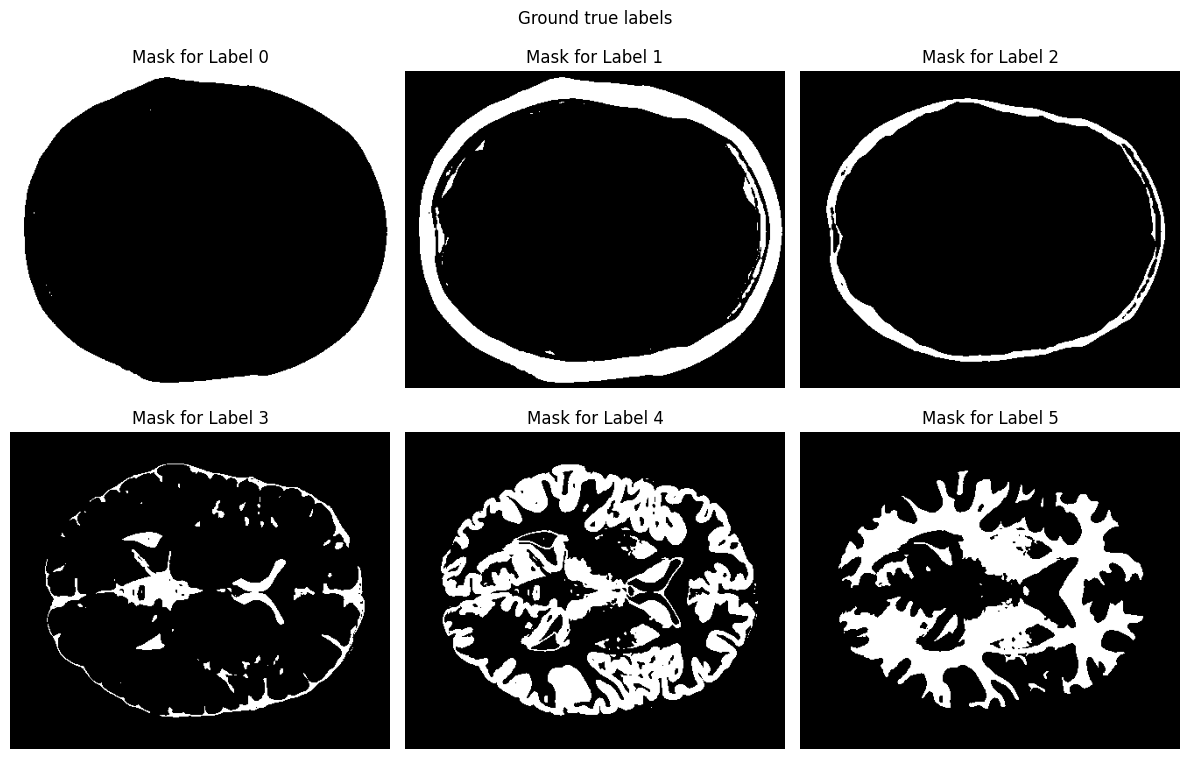

In [30]:
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(reference_labels == i, cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')

plt.suptitle("Ground true labels")
plt.tight_layout()
plt.show()


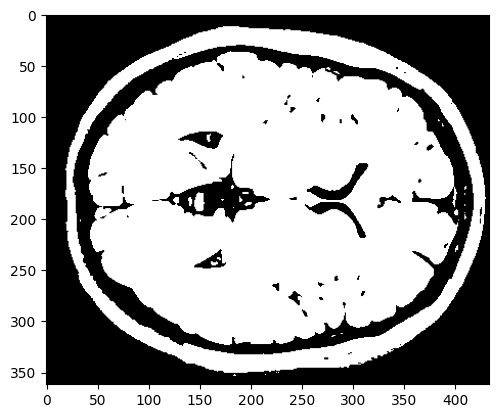

In [31]:
from skimage.filters import threshold_otsu

# 1. Apply an outsu algorithm to the reference image
threshold = threshold_otsu(reference_img)
binary = reference_img > threshold

# Plot the binary image
plt.imshow(binary, cmap='gray')

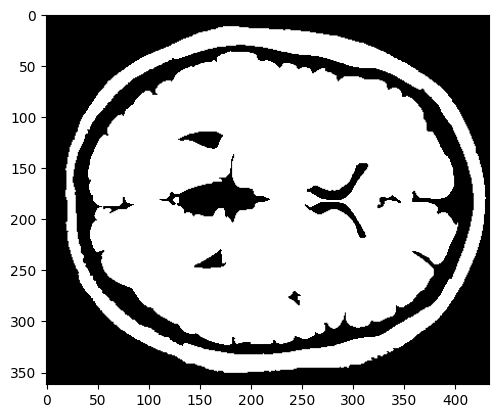

In [32]:
# 2. Remove the smaller artifict within each white or black region
from skimage.morphology import remove_small_objects, remove_small_holes

cleaned = remove_small_holes(binary)
cleaned = remove_small_objects(cleaned, min_size=1000)

# Plot the cleaned image
plt.imshow(cleaned, cmap='gray')

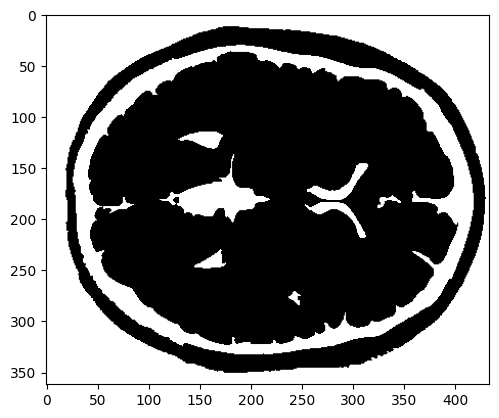

In [33]:
# 4. From cleaned image get four labels mask
# NOTE: I can get two mask 3 characteristic labels from the inverted cleaned image

# Invert the cleaned image
inverted = ~cleaned

# Plot the inverted image
plt.imshow(inverted, cmap='gray')

Number of labels: 10


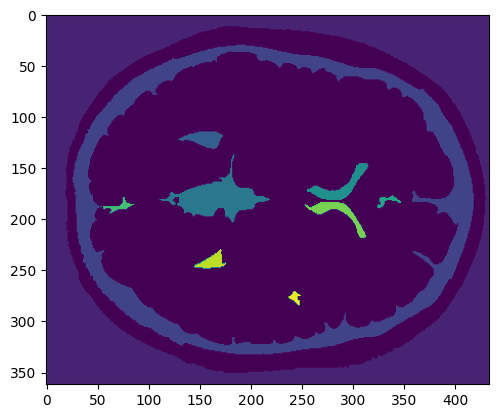

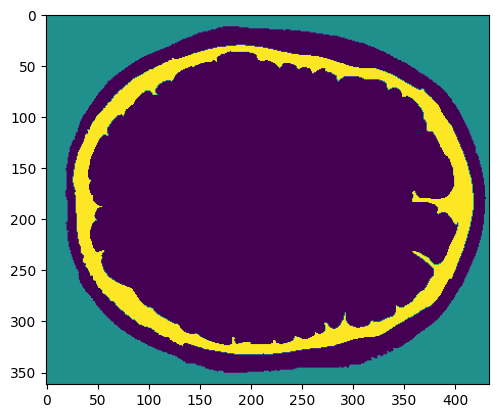

In [34]:
import scipy.ndimage as ndimage

# Apply two-pass algorithm to the inverted image
inverted_labels, num_labels = ndimage.label(inverted)

# Print the number of labels
print("Number of labels:", num_labels)

# Plot the labeled image
plt.imshow(inverted_labels)
plt.show()

# Only consider the two first labels and all the others as background
inverted_labels[inverted_labels > 2] = 0

plt.imshow(inverted_labels)
plt.show()

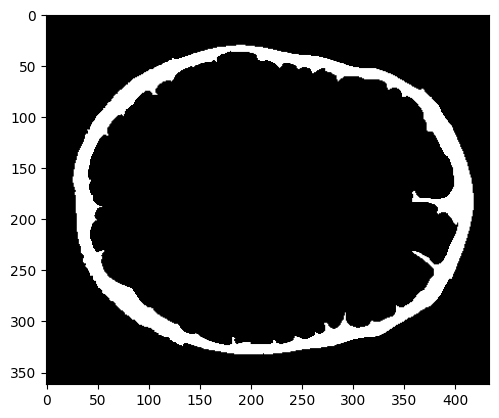

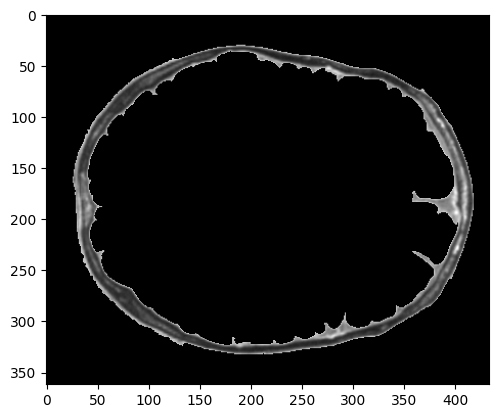

In [37]:
# Get the mask 2
mask1 = inverted_labels == 2

# Plot the mask 2
plt.imshow(mask1, cmap='gray')
plt.show()

# Apply the mask on the reference image
masked_img1 = reference_img * mask1

# Plot the masked image
plt.imshow(masked_img1, cmap='gray')
plt.show()

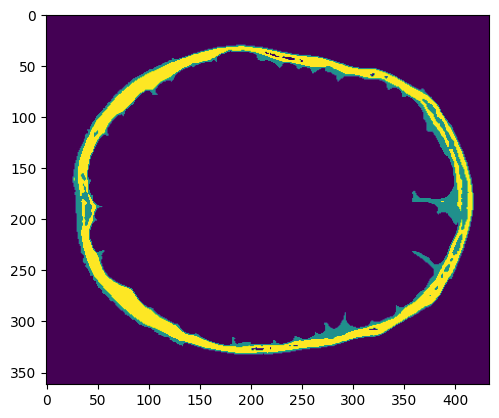

In [40]:
# Apply K-means clustering to the masked_img1
from sklearn.cluster import KMeans

# Reshape the image to 1D array
X = masked_img1.reshape(-1, 1)

# Apply K-means clustering
kmeans = KMeans(n_clusters=3, random_state=0).fit(X)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Get the cluster labels
labels = kmeans.labels_

# Reshape the labels to the original image shape
labels = labels.reshape(masked_img1.shape)

# Plot the cluster labels
plt.imshow(labels)
plt.show()

Number of labels: 2


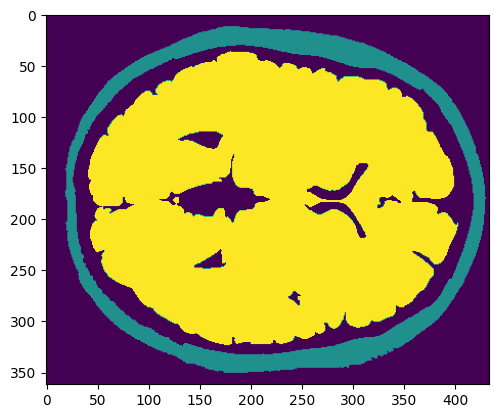

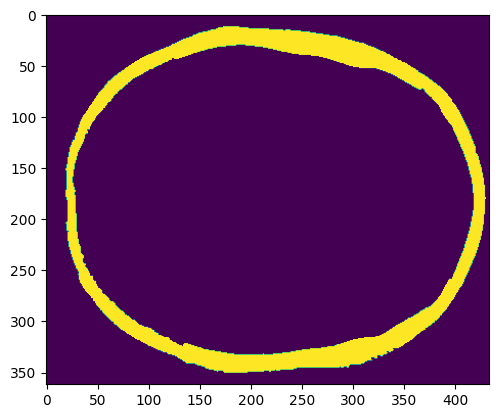

In [63]:
import scipy.ndimage as ndimage


# NOTE: I can get one additional from the cleaned image
# In principel, I got 3, but I focus on the first label
# Apply two-pass algorithm to the cleaned image
labels, num_labels = ndimage.label(cleaned)

# Print the number of labels
print("Number of labels:", num_labels)

# Plot the labeled image
plt.imshow(labels)
plt.show()

# Keep only label 1 and change to type int
labels_cleaned = (labels == 1).astype(int)

# Plot the mask
plt.imshow(labels_cleaned)
plt.show()

In [64]:
print(inverted_labels.min())
print(inverted_labels.max())

0
2


In [65]:
print(mask.min())
print(mask.max())

0.0
336326.62


0
3


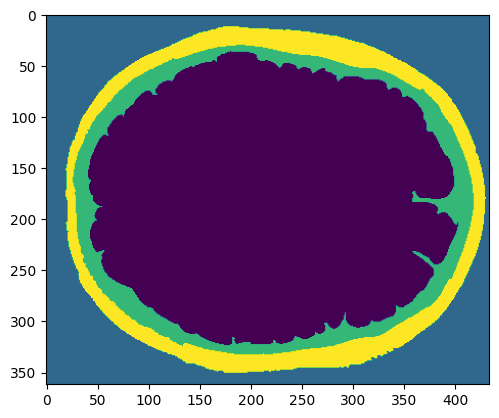

In [66]:
# NOTE: I add the two mask to get the external labels
# And multiply labels_cleaned by 3 to get different labels per each region

# Sum the two masks
external_labels = labels_cleaned * 3 + inverted_labels

# Plot the final mask
plt.imshow(external_labels)

print(external_labels.min())
print(external_labels.max())

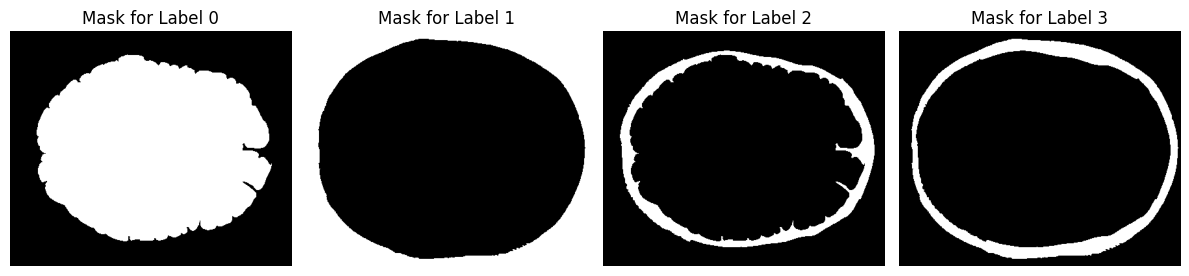

In [67]:
# Show each label separately
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    mask = external_labels == i
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [68]:
# Until this point we have four regions and the internal region defined as background

# We need to do two things
# 1. get the mask of the internal region
# 2. replace the labels values with the correct value

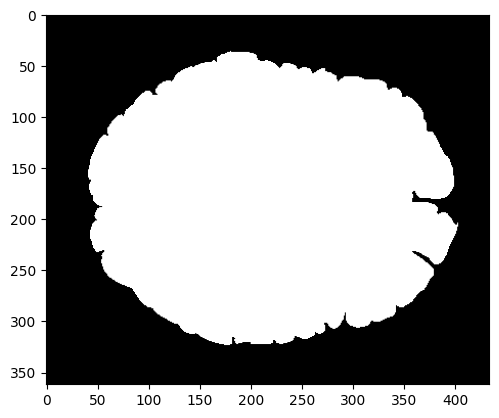

In [69]:
# 1. get the mask of the internal region
# Set to 1 the labels 0 (of the internal region) and set to 0 all the other labels
internal_mask = external_labels.copy() * 10 # Trick to replace the labels
internal_mask[internal_mask == 0] = 1
internal_mask[internal_mask != 1] = 0

# Plot the final mask
plt.imshow(internal_mask, cmap='gray')

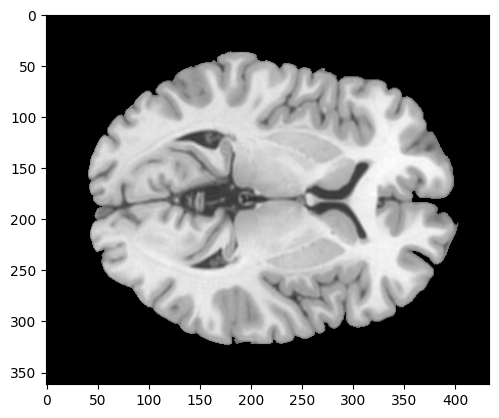

In [70]:
# Get the internal region of the reference image using the mask
partial_reference = reference_img * internal_mask

# Plot the final mask on reference_img
plt.imshow(partial_reference, cmap='gray')

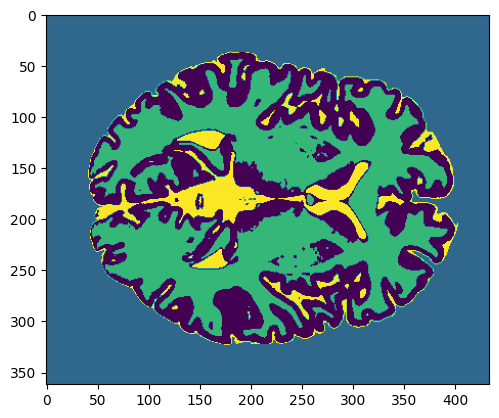

In [71]:
# Apply k-means clustering to the partial_reference image
from sklearn.cluster import KMeans

# Reshape the image to a 2D array
X = partial_reference.reshape(-1, 1)

# Fit KMeans to the data
kmeans = KMeans(n_clusters=4, random_state=0).fit(X)

# Predict the labels for the data
internal_labels = kmeans.predict(X)

# Reshape the labels to the original image shape
internal_labels = internal_labels.reshape(partial_reference.shape)

# Plot the labels
plt.imshow(internal_labels)

In [72]:
# 2. replace the labels values with the correct value

# NOTE: To avoid confusion I multiply by 10 and 100 the temporal labels
tmp_external_labels = external_labels * 10
tmp_internal_labels = internal_labels * 100


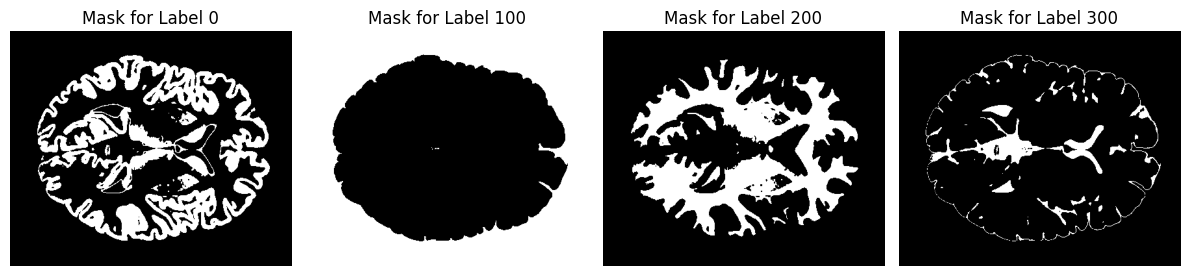

In [73]:
# Show each label separately
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    mask = tmp_internal_labels == (i * 100)
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Mask for Label {(i * 100)}')
    ax.axis('off')

plt.tight_layout()
plt.show()

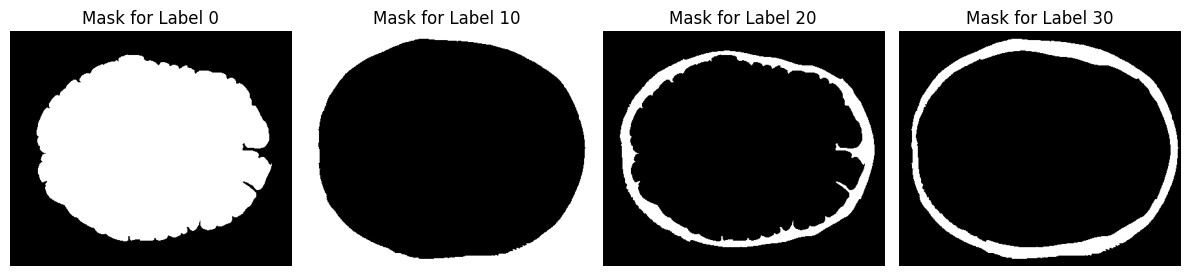

In [74]:
# Show each label separately
fig, axes = plt.subplots(1, 4, figsize=(12, 6))

for i, ax in enumerate(axes.flat):
    mask = tmp_external_labels == (i * 10)
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Mask for Label {(i * 10)}')
    ax.axis('off')

plt.tight_layout()
plt.show()

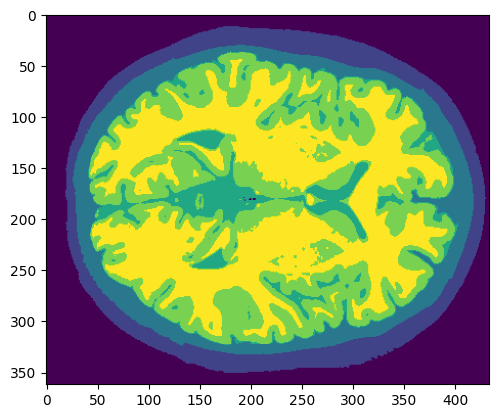

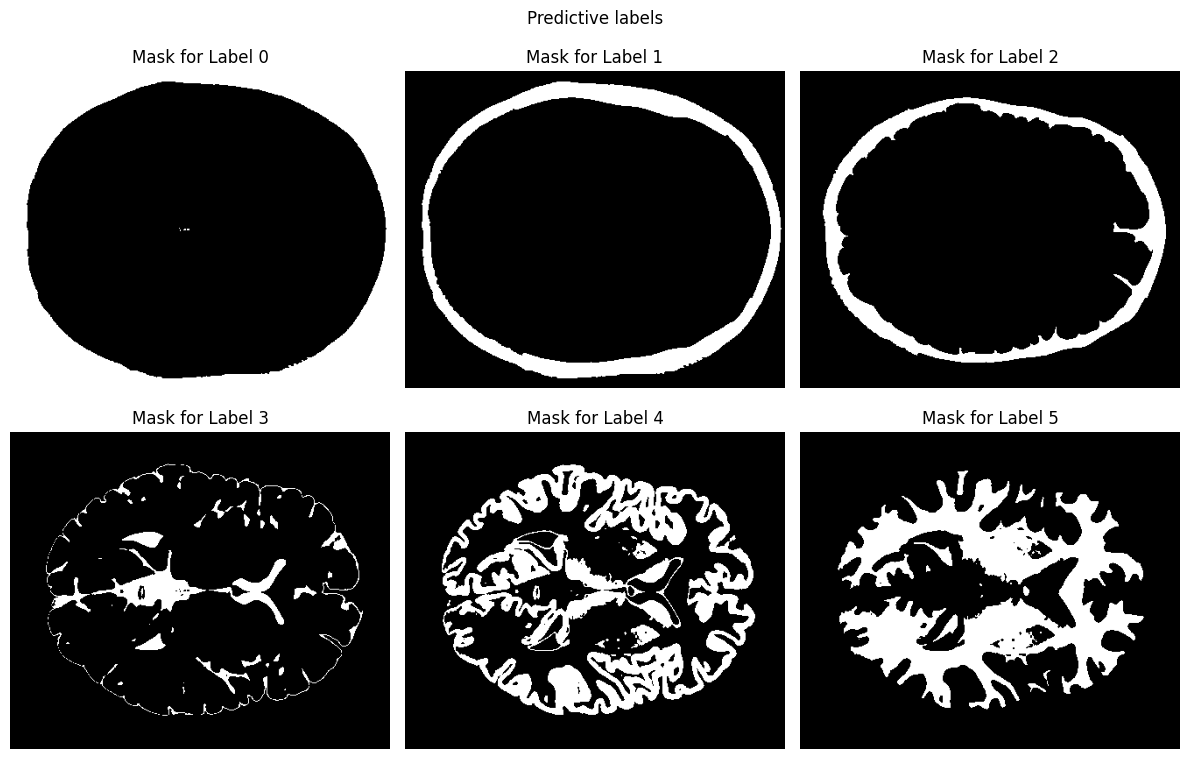

In [91]:
# Map the temporal labels to the final labels
external_temp2labels = {
    10 : 0,
    30 : 1,
    20 : 2,
}

internal_temp2labels = {
    300 : 3,
    0 : 4,
    200 : 5
}


segmented_labels = np.zeros_like(reference_img)

for temp_label, label in external_temp2labels.items():
    segmented_labels[tmp_external_labels == temp_label] = label

for temp_label, label in internal_temp2labels.items():
    segmented_labels[tmp_internal_labels == temp_label] = label

# Plot the final mask
plt.imshow(segmented_labels)

# Show each label separately
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    mask = segmented_labels == i
    ax.imshow(mask, cmap='gray')
    ax.set_title(f'Mask for Label {i}')
    ax.axis('off')
plt.suptitle("Predictive labels")
plt.tight_layout()
plt.show()

In [78]:
# Print the number of pixels per label
for i in range(6):
    print(f"Label {i}: {np.sum(reference_labels == i)} pixels")

# NOTE: clearly we have an imbalance in the number of pixels per label

Label 0: 41630 pixels
Label 1: 24071 pixels
Label 2: 9093 pixels
Label 3: 9788 pixels
Label 4: 37858 pixels
Label 5: 34668 pixels


In [87]:
# segmented_labels is my prediction and reference_labels is the ground truth

from sklearn.metrics import jaccard_score, f1_score, confusion_matrix, accuracy_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import jaccard_score

# Flatten the arrays
y_true = reference_labels.flatten()
y_pred = segmented_labels.flatten()

# Compute the metrics
accuracy = accuracy_score(y_true, y_pred)
# Flatten the arrays
y_true = reference_labels.flatten()
y_pred = segmented_labels.flatten()


jaccard_index = jaccard_score(y_true, y_pred, average=None)
precision = precision_score(y_true, y_pred, average=None)
recall = recall_score(y_true, y_pred, average=None)
f1 = f1_score(y_true, y_pred, average=None)

# Compute micro metrics
micro_jaccard = jaccard_score(y_true, y_pred, average='micro')
micro_precision = precision_score(y_true, y_pred, average='micro')
micro_recall = recall_score(y_true, y_pred, average='micro')
micro_f1 = f1_score(y_true, y_pred, average='micro')

# Compute macro metrics
macro_jaccard = jaccard_score(y_true, y_pred, average='macro')
macro_precision = precision_score(y_true, y_pred, average='macro')
macro_recall = recall_score(y_true, y_pred, average='macro')
macro_f1 = f1_score(y_true, y_pred, average='macro')

# Print the Jaccard Index
print("accuracy:", accuracy)
print("Jaccard Index:", jaccard_index)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1, "\n")

print("Micro Jaccard Index:", micro_jaccard)
print("Micro Precision:", micro_precision)
print("Micro Recall:", micro_recall)
print("Micro F1 Score:", micro_f1)

print("Macro Precision:", macro_precision)
print("Macro Recall:", macro_recall)
print("Macro F1 Score:", macro_f1)
print("Macro Jaccard Index:", macro_jaccard)


accuracy: 0.9118759070193752
Jaccard Index: [0.93745495 0.73569856 0.58180306 0.50803578 0.8830316  0.9630535 ]
Precision: [0.93760278 1.         0.58180306 0.69298056 0.98927284 0.9630535 ]
Recall: [0.99983185 0.73569856 1.         0.65559869 0.89156849 1.        ]
F1 Score: [0.96771794 0.84772618 0.7356201  0.67377152 0.93788293 0.98117907] 

Micro Jaccard Index: 0.8380256561745041
Micro Precision: 0.9118759070193752
Micro Recall: 0.9118759070193752
Micro F1 Score: 0.9118759070193752
Macro Precision: 0.8607854562228887
Macro Recall: 0.8804495992543654
Macro F1 Score: 0.8573162905437944
Macro Jaccard Index: 0.76817957715507


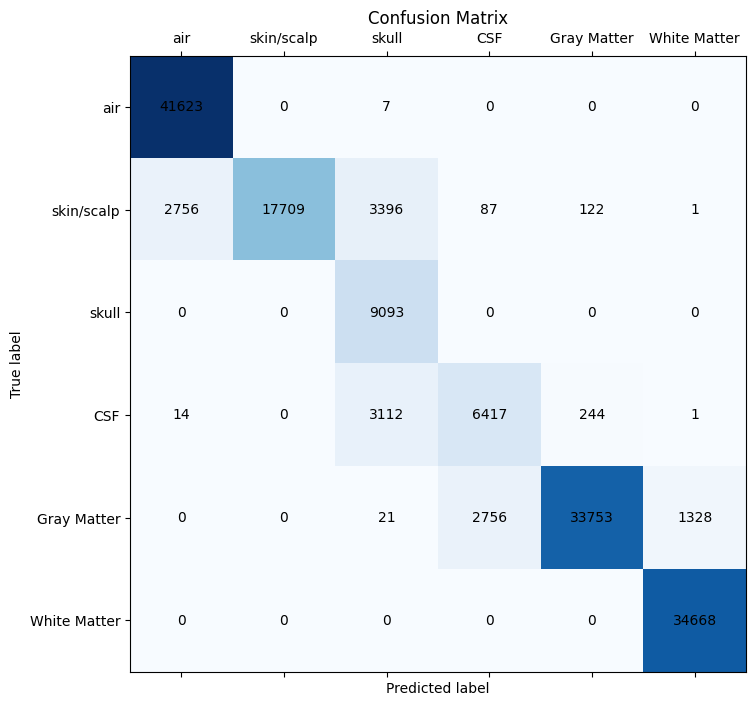

In [83]:
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
ax.matshow(conf_matrix, cmap='Blues')

# Add the matrix values
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, str(conf_matrix[i, j]), va='center', ha='center')

# Set the title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

# Set the ticks
ax.set_xticks(range(6))
ax.set_yticks(range(6))

# Set the labels
ax.set_xticklabels(label_names)
ax.set_yticklabels(label_names)

# Show the plot
plt.show()


- [IDEAS] Possible way to smooth the contours
- Smooth with dilatation or erotion

# First try to include the part of label 3
# Idea apply a KNN clustering only between labels 1 and 2
